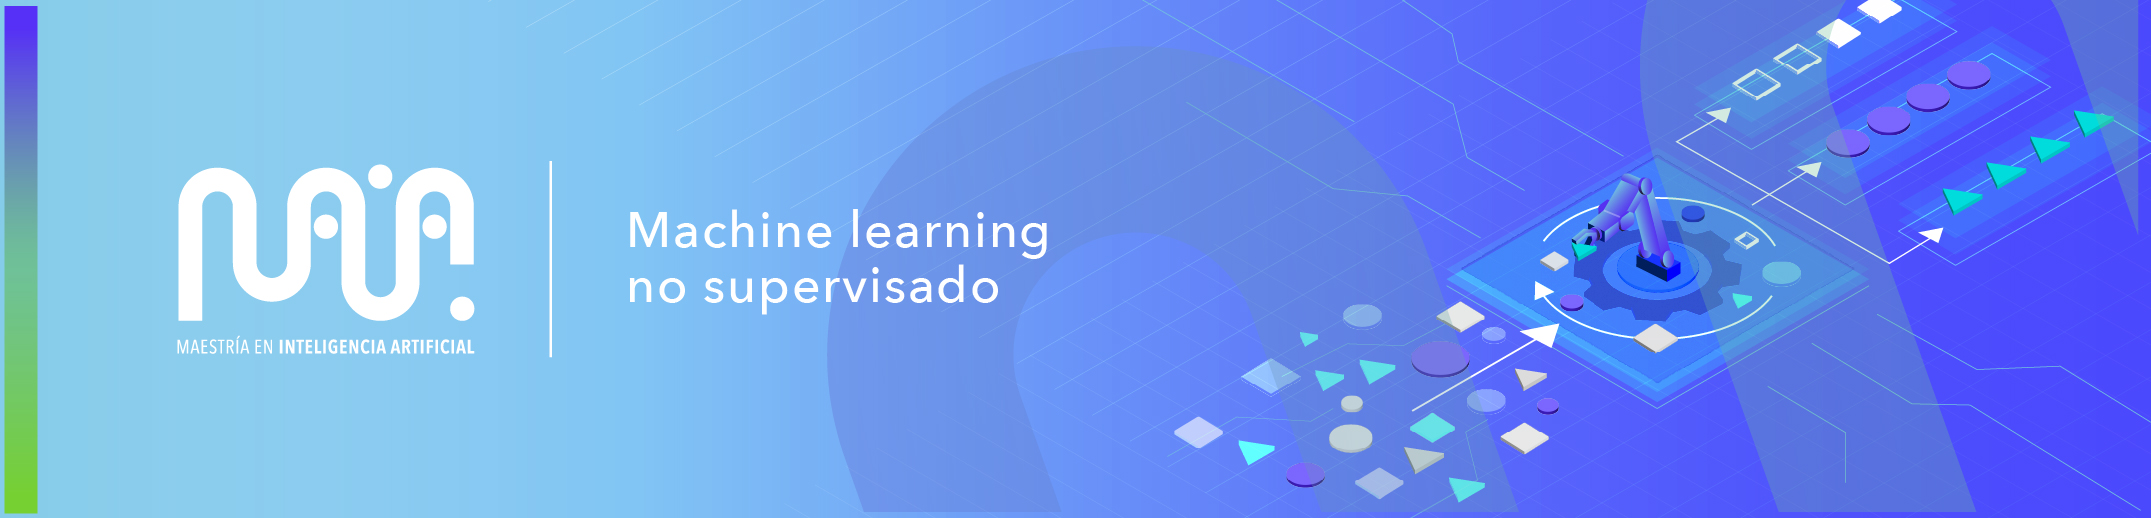


# Solución de problemas con KMeans y KMedoides - caso real

En este tutorial aprenderás cómo crear un modelo de agrupación haciendo uso del algoritmo KMeans y del algoritmo KMedoides, utilizando un conjunto de datos más realista. En particular, realizarás una selección del hiperparámetro k mediante el método del codo y el método de la silueta, interpretando los grupos del mejor modelo de agrupación resultante. En este sentido, veremos cómo realizar los siguientes procesos:

1. [Importar las librerías necesarias.](#1.-Importación-de-librerías-requeridas)
2. [Cargar un conjunto de datos procesado.](#2.-Carga-de-datos)
3. [Seleccionar el hiperparámetro K para KMeans mediante el método del codo y el método de la silueta.](#3.-Selección-del-hiperparámetro-K-para-KMeans)
4. [Seleccionar el hiperparámetro K para KMedoides mediante el método del codo y el método de la silueta.](#4.-Selección-del-hiperparámetro-K-para-KMedoides)
5. [Interpretar los grupos resultantes del mejor modelo.](#5.-Interpretación-de-los-grupos-resultantes-del-mejor-modelo)

---

<font size="3">**Contexto**  
<font size="2">El conjunto de datos que utilizaremos corresponde a la caracterización de clientes para una campaña publicitaria, que fue preparadp en el tutorial de la semana 1.

## 1. Importación de librerías requeridas

Importaremos las librerías `pandas`, `numpy`, `joblib` y `scikit-learn`, así como la librería `sklearn_extra` para usar el algoritmo KMedoides. Adicionalmente, importaremos dos librerías para visualización: `matplotlib` y `seaborn`. Usaremos las siguientes clases y funciones para entrenar y evaluar los modelos de agrupación:

* [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html): función para obtener el valor promedio del coeficiente de la silueta.
* [`silhouette_samples()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html): función para obtener el coeficiente de la silueta para cada ejemplo.
* [`KMeans()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html): clase para crear el modelo de KMeans.
* [`KMedoids()`](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html): clase para crear el modelo de KMedoides.

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

## 2. Carga de datos

Realizaremos la carga de datos ya procesados usando la función de Pandas `read_csv()`, especificando la ruta y el separador del archivo:

In [2]:
data = pd.read_csv('data/marketing_campaign_processed.csv', sep=',')

Además, cargaremos el objeto `transformer` almacenado en el Tutorial 1:

In [3]:
transformer = joblib.load('obj/transformer')

Veamos los primeros datos del conjunto utilizando `head()`:

In [4]:
data.head()

,num__Year_Birth,num__Income,num__Kidhome,num__Teenhome,num__Recency,num__MntWines,num__MntFruits,num__MntMeatProducts,num__MntFishProducts,num__MntSweetProducts,...,cat__Education_Master,cat__Education_PhD,cat__Marital_Status_Absurd,cat__Marital_Status_Alone,cat__Marital_Status_Divorced,cat__Marital_Status_Married,cat__Marital_Status_Single,cat__Marital_Status_Together,cat__Marital_Status_Widow,cat__Marital_Status_YOLO
0,-0.984645,0.244084,-0.829097,-0.932051,0.312088,0.984044,1.554193,1.657389,2.464511,1.458453,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.235251,-0.212615,1.031625,0.898255,-0.377754,-0.870634,-0.634978,-0.708461,-0.646539,-0.627684,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.316363,0.765876,-0.829097,-0.932051,-0.791659,0.362846,0.572841,-0.178335,1.348193,-0.148113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.270808,-0.975381,1.031625,-0.932051,-0.791659,-0.870634,-0.559489,-0.647124,-0.500137,-0.579727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.020202,0.250086,1.031625,-0.932051,1.553804,-0.389131,0.421863,-0.217766,0.158674,-0.004241,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Como puedes observar, nuestro conjunto de datos ya está estandarizado y las variables categóricas ya están representadas mediante la codificación OneHot. Además, no tenemos datos nulos ni duplicados. En este tutorial ejecutaremos KMeans y KMedoides con todas las variables del conjunto de datos.

## 3. Selección del hiperparámetro K para KMeans

Realizaremos dos pruebas para la selección del hiperparámetro _k_: el método del codo y el método de la silueta. Estos métodos permiten comparar la naturaleza de los clusters formados con los algoritmos de agrupación, cuantificando la distancia de los puntos a su centroide. Empezaremos con el método del codo. 

### Método del codo

Primero intentaremos buscar el mejor valor de _k_, representado por el parámetro `n_clusters` de `KMeans`, mediante el método del codo. Definiremos la misma función `elbow_plot()`, que ejecutará el algoritmo de agrupación con cada valor de _k_ definido por el rango `[k_min, k_max]`, generando una gráfica con los valores de inercia resultantes:

In [5]:
def elbow_plot(X, model, k_min=2, k_max=10):
    """
    Genera la gráfica para el método del codo usando KMeans
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    inertias = []
    for i in range(k_min, k_max+1):
        if model == "kmeans":
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
        else:
            model_k = KMedoids(n_clusters=i, max_iter=300, random_state=0)
        # Entrenamos el modelo
        model_k.fit(X)
        # Almacenamos el valor de inercia
        inertias.append(model_k.inertia_)
    
    # Graficamos los valores de inercia
    plt.plot(range(k_min,k_max+1), inertias, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inercia')
    plt.grid()
    plt.show()

Con la función construida, veremos el comportamiento para nuestro conjunto de datos:

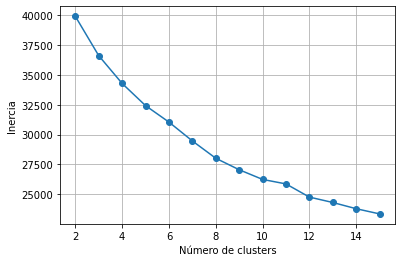

In [6]:
elbow_plot(data, "kmeans", 2, 15)

Como recordarás, el mejor valor de _k_ se determina con el punto después del cual la inercia empieza a tener un comportamiento aproximadamente lineal. Ten en cuenta que este método es una heurística que puede o no ser efectiva dependiendo de los datos, por lo que en situaciones donde la inercia no tiene un codo claro, como en la gráfica anterior, la determinación del valor de _k_ no es evidente.

### Método de la silueta

El método de la silueta es un tipo de análisis que mide la separación entre los clusters obtenidos en algoritmos de agrupación. Para este análisis, utilizaremos la función `silhouette_score()` de `scikit-learn`, definiendo la misma función `silhouette_plot()`, que calcula el coeficiente promedio para varios valores de _k_ y los grafica:

In [7]:
def silhouette_plot(X, model, k_min=2, k_max=5):
    """
    Genera la gráfica con el coeficiente de la silueta
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    scores = []
    for i in range(k_min, k_max+1):
        if model == "kmeans":
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
        else:
            model_k = KMedoids(n_clusters=i, max_iter=300, random_state=0)
        # Entrenamos el modelo
        model_k.fit(X)
        # Almacenamos el coeficiente de la silueta
        score = silhouette_score(X, model_k.labels_)
        scores.append(score)
    
    # Graficamos los valores del coeficiente de la silueta
    plt.plot(range(k_min,k_max+1), scores, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

Veremos el comportamiento del coeficiente para nuestro conjunto de datos:

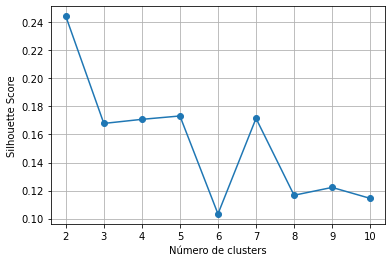

In [8]:
silhouette_plot(data, "kmeans", 2, 10)

Como puedes observar, aunque se tienen valores bajos, es más evidente que el mejor valor de _k_ es 2, al ser el valor más cercano a 1 para el coeficiente de la silueta. Sin embargo, es posible que nuestro conjunto de datos no tenga grupos fácilmente separables, lo que explicaría los resultados obtenidos con el método del codo y de la silueta.

Realizaremos una descripción más detallada del coeficiente de la silueta para cada cluster en cada escenario, definiendo la misma función `silhouette_analysis()`:

In [9]:
def silhouette_analysis(X, model, k_min, k_max):
    """
    Genera gráficas con el coeficiente de la silueta para cada cluster y cada ejemplo
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    for n_clusters in range(k_min, k_max+1):
        if model == "kmeans":
            clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
        else:
            clusterer = KMedoids(n_clusters=n_clusters, random_state=0)
        
        # Entrenamos el modelo
        cluster_labels = clusterer.fit_predict(X)
        # Obtenemos el coeficiente promedio
        silhouette_avg = silhouette_score(X, cluster_labels)
        # Obtenemos el coeficiente para cada ejemplo
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        
        # Inicializamos una figura
        fig = plt.figure(figsize = (18, 7))
        plt.xlim([-0.2, 1])
        plt.ylim([0, len(X) + (n_clusters + 1) * 10])
        
        y_lower = 10
        for i in range(n_clusters):
            # Obtenemos los valores del coeficiente para cada cluster
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            # Ordenamos los valores de mayor a menor
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            plt.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
            
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        plt.title(f"Método de la silueta (k={n_clusters})")
        plt.xlabel("Coeficiente")
        plt.ylabel("Cluster")
        
        # Incluimos el valor promedio
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.yticks([])
        plt.xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

Realizaremos el análisis específico para el mismo rango de _k_:

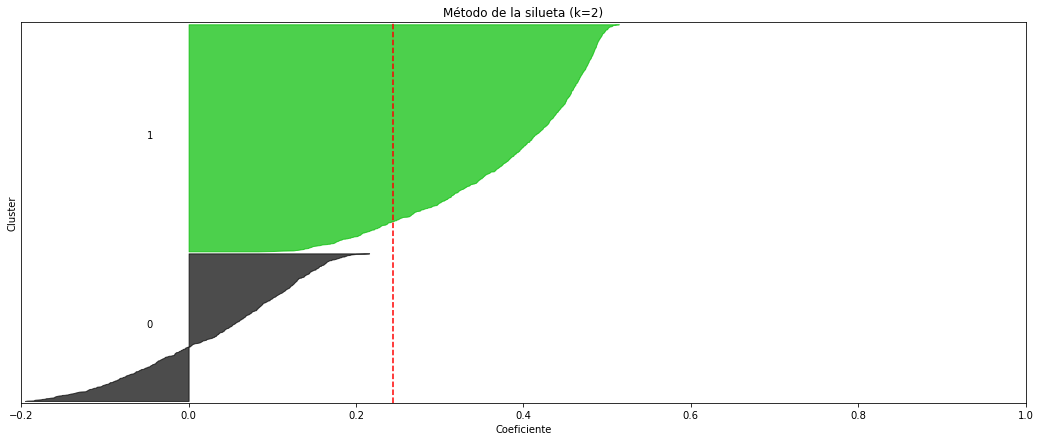

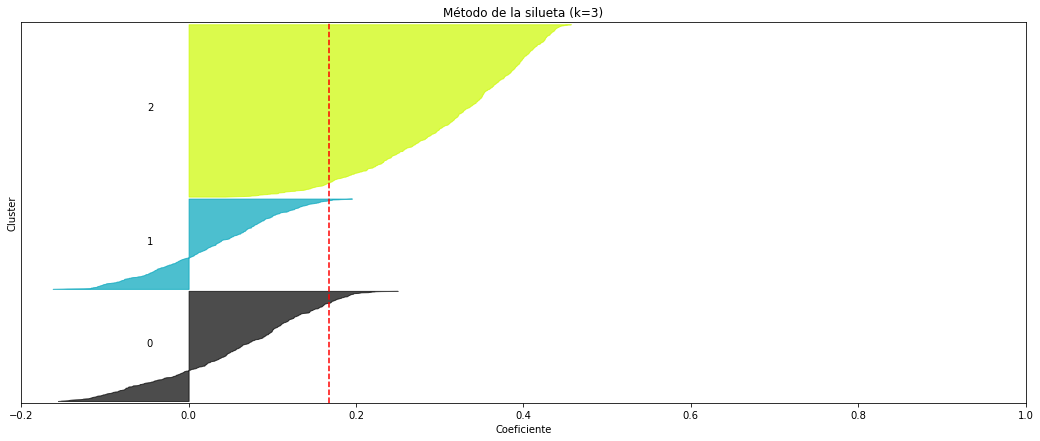

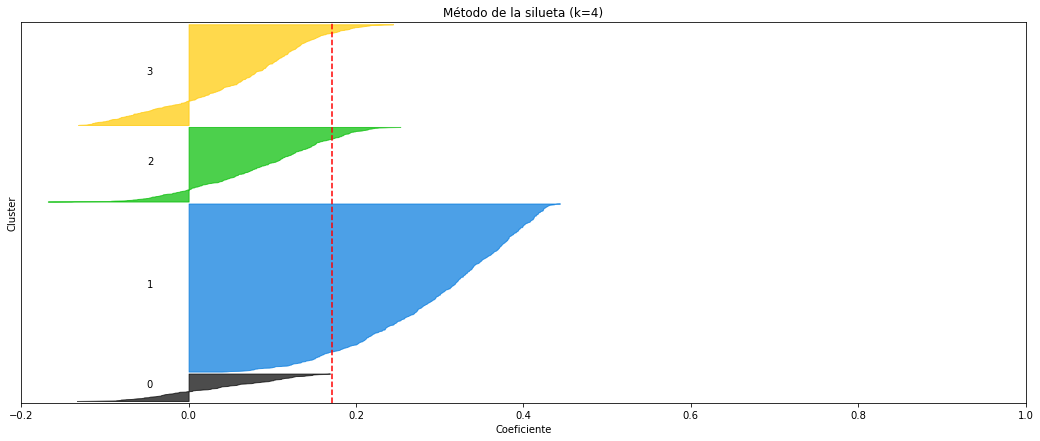

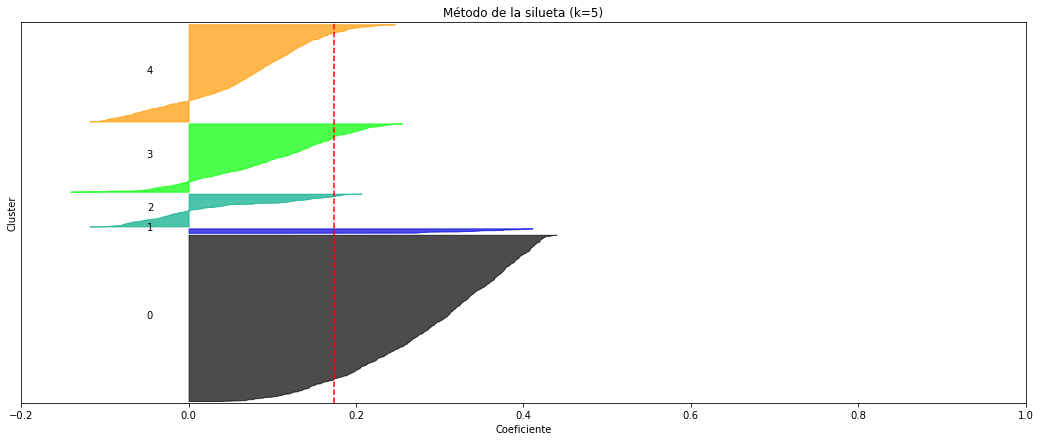

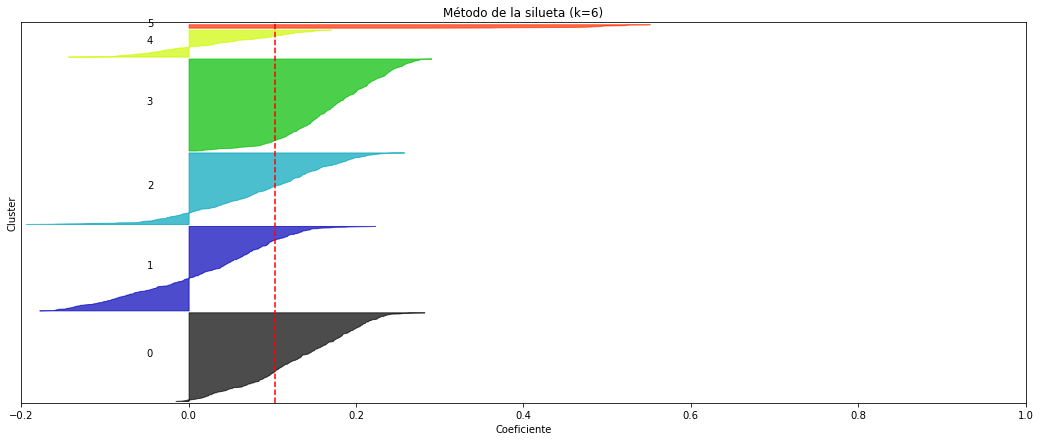

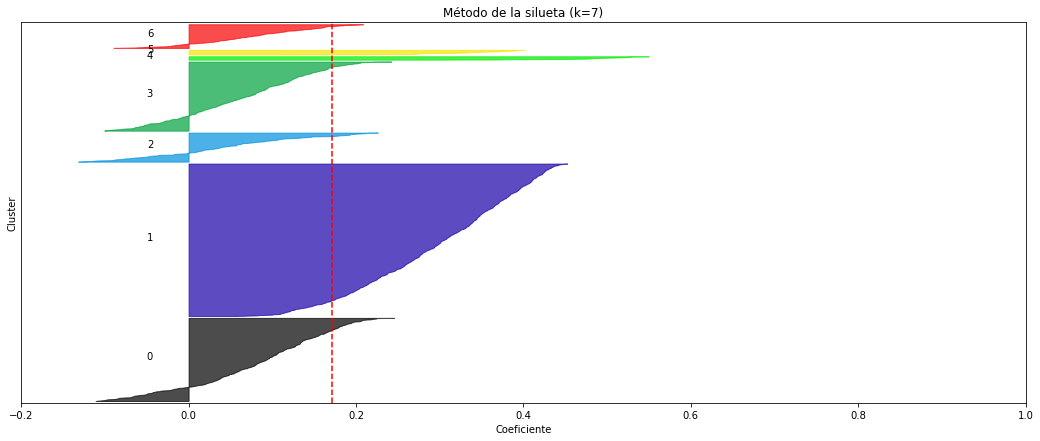

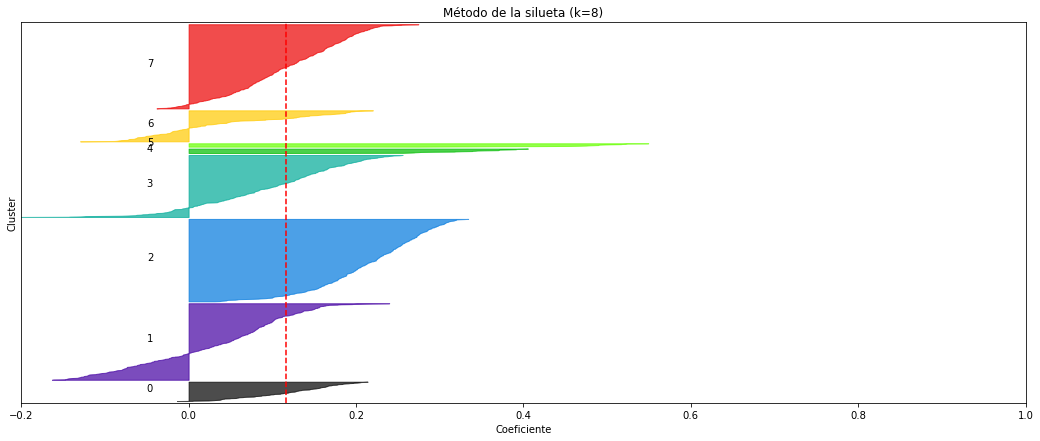

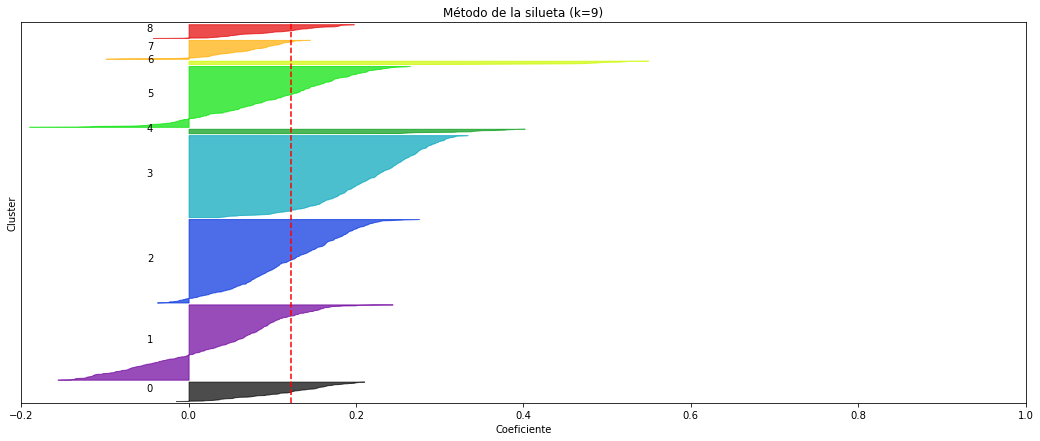

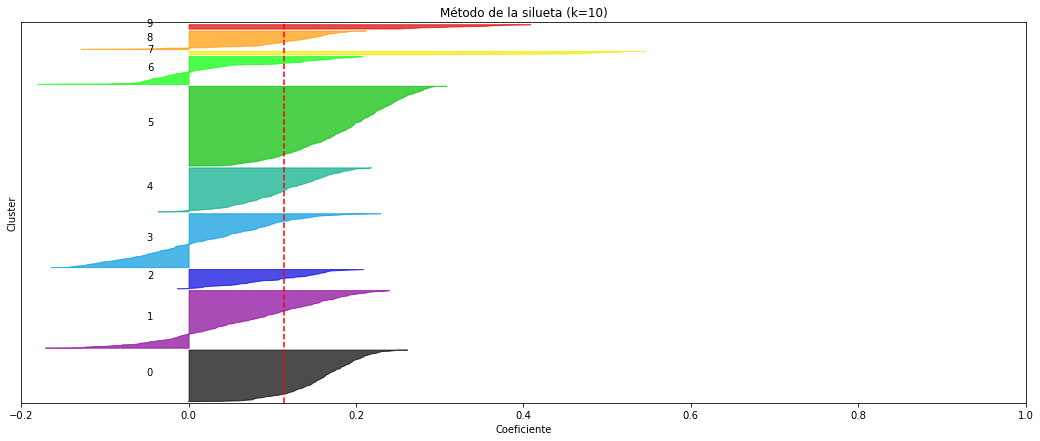

In [10]:
silhouette_analysis(data, "kmeans", 2, 10)

Si tomamos como ejemplo la gráfica para `k=3`, podemos observar los tamaños de los clusters y el comportamiento de cada ejemplo asignado a ellos. Inicialmente, el cluster 2 es al que pertenece la mayor cantidad de datos, y todos ellos tienen un valor positivo para el coeficiente de la silueta, lo que indica que están bien clasificados. Por otro lado, los clusters 0 y 1 tienen una cantidad considerable de ejemplos con un coeficiente negativo, lo que indica que son ejemplos que están más cerca a otro cluster que al que fueron asignados.

## 4. Selección del hiperparámetro K para KMedoides

Ahora utilizaremos las mismas funciones pero cambiando el algoritmo a KMedoides. Este algoritmo también intenta minimizar las distancias entre puntos en un cluster y su centro pero, a diferencia de KMeans, utiliza uno de los datos como centroide para cada cluster.

### Método del codo

Primero intentaremos buscar el mejor valor de _k_, representado por el parámetro `n_clusters` de `KMedoids`, mediante el método del codo implementado en la función `elbow_plot()`:

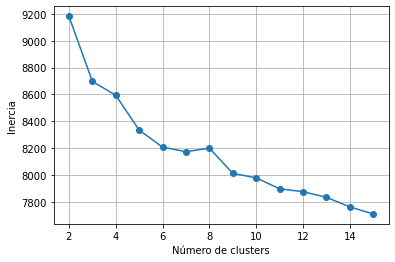

In [11]:
elbow_plot(data, "kmedoids", 2, 15)

Teniendo en cuenta que nuestro algoritmo está inicializado solamente con los parámetros `n_clusters`, `max_iter` y `random_state`, estamos utilizando la distancia euclidiana (parámetro `metric`) y una heurística para inicializar los centroides como los puntos con una menor suma de distancias a los demás puntos (parámetro `init`). 

Ten en cuenta que, aunque la métrica de distancia es igual a la clase `KMeans`, los valores de inercia para la clase `KMedoids` se calculan como la suma de las distancias de cada punto a su centroide, mientras que en el caso anterior se calculaban como las distancias al cuadrado. Igualmente, estamos utilizando las variables binarias y midiendo la distancia euclidiana, lo que puede no ser muy acertado.

### Método de la silueta

Ahora utilizaremos la función `silhouette_plot()` para calcular el coeficiente promedio para varios valores de _k_ usando KMedoides:

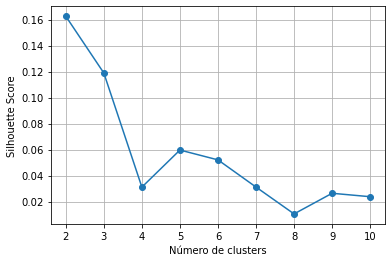

In [12]:
silhouette_plot(data, "kmedoids", 2, 10)

Como puedes observar, aunque se tienen valores bajos, es más evidente que el mejor valor de _k_ es 2, al ser el valor más cercano a 1 para el coeficiente de la silueta. Al igual que utilizando KMeans, los valores del coeficiente nos indican que es posible que nuestro conjunto de datos no tenga grupos fácilmente separables.

En este caso, como solo necesitamos las etiquetas de cluster asignadas a cada punto para calcular el coeficiente de la silueta, podemos comparar directamente el desempeño de ambos algoritmos. En ese sentido, podemos evidenciar que KMeans parece resultar en clusters mejor definidos, al tener un valor máximo más alto. Igualmente, realizaremos el mismo análisis detallado mediante la función `silhouette_analysis()`:

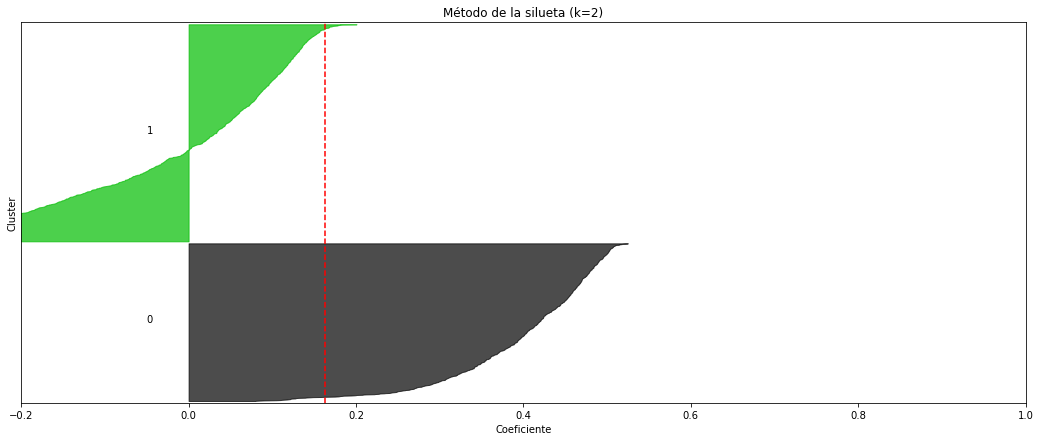

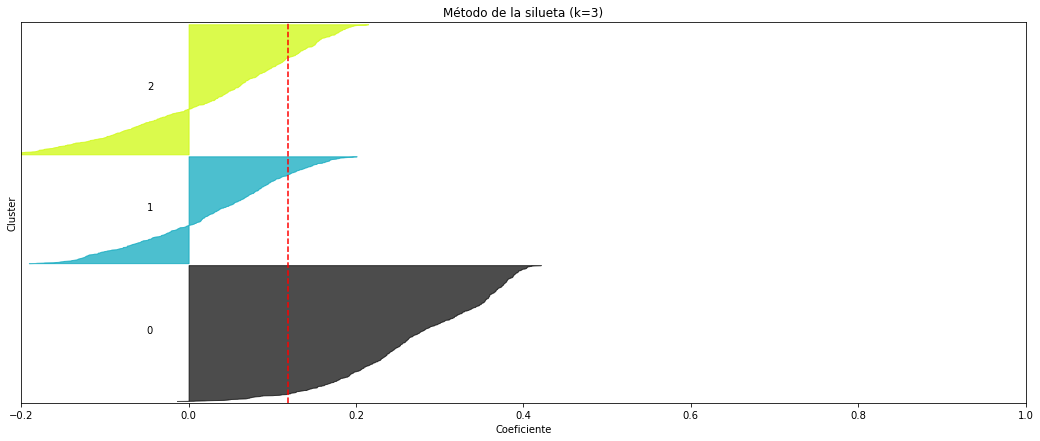

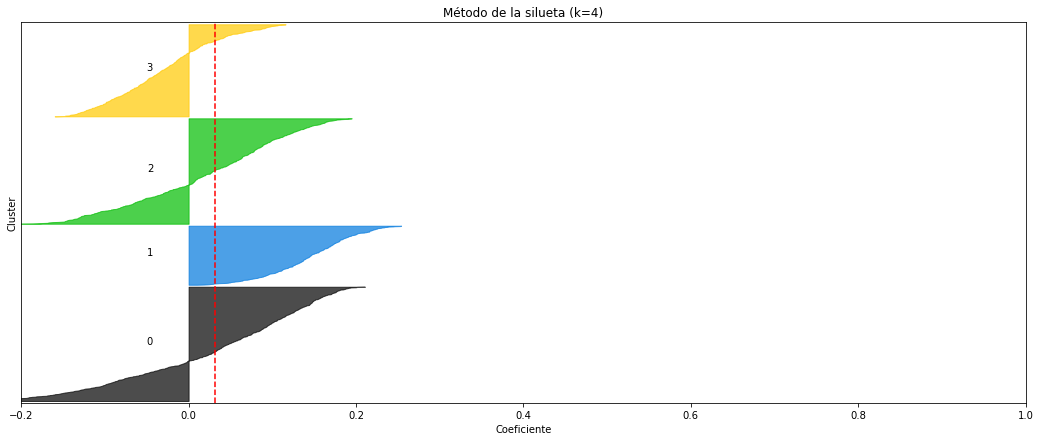

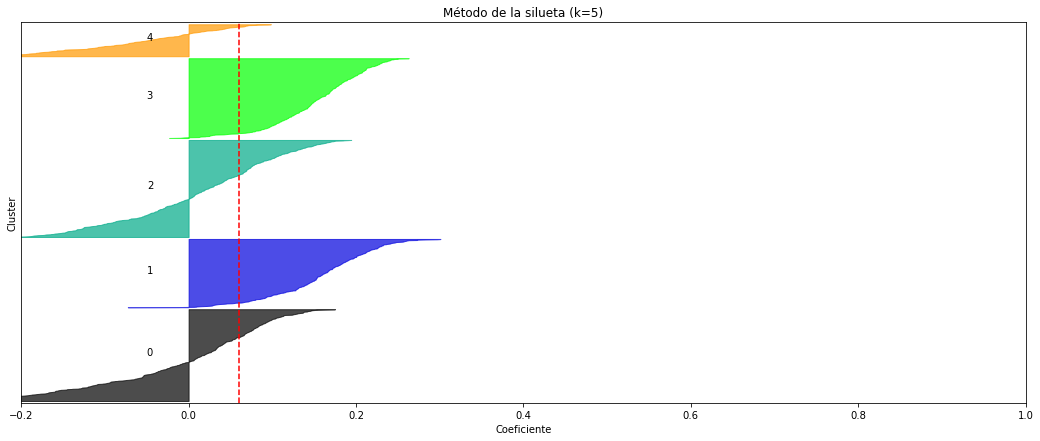

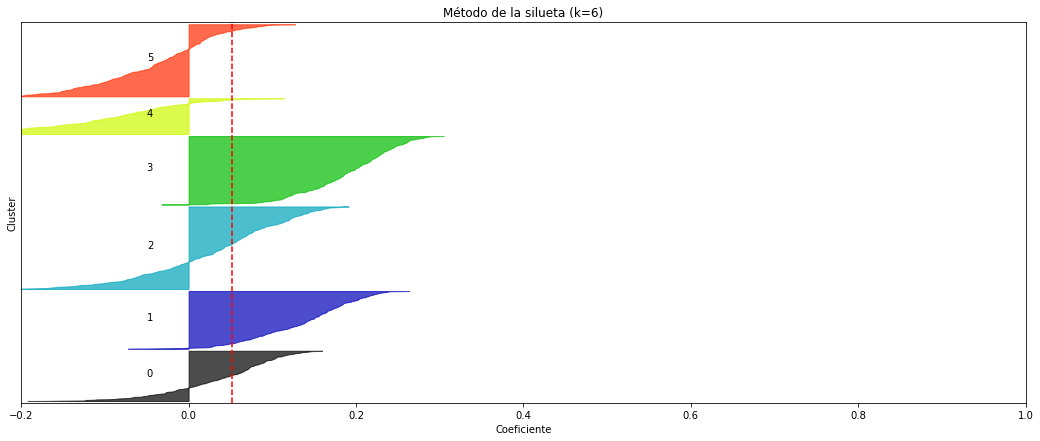

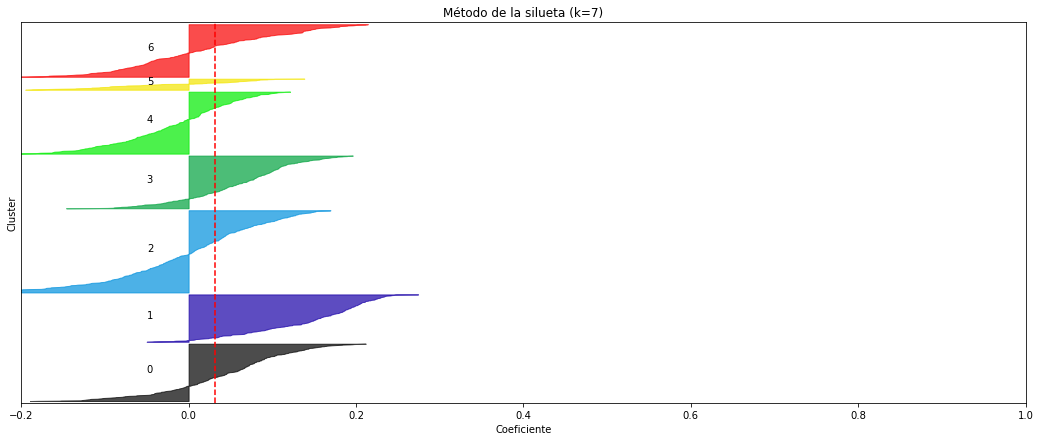

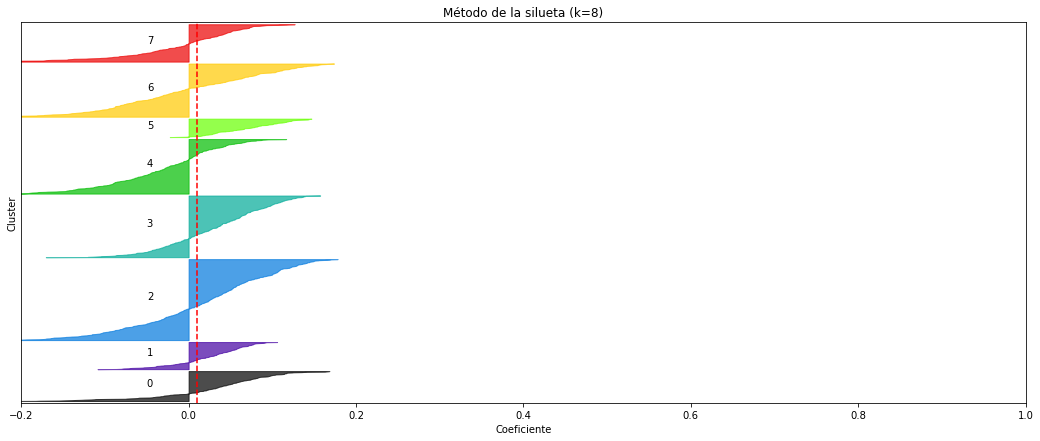

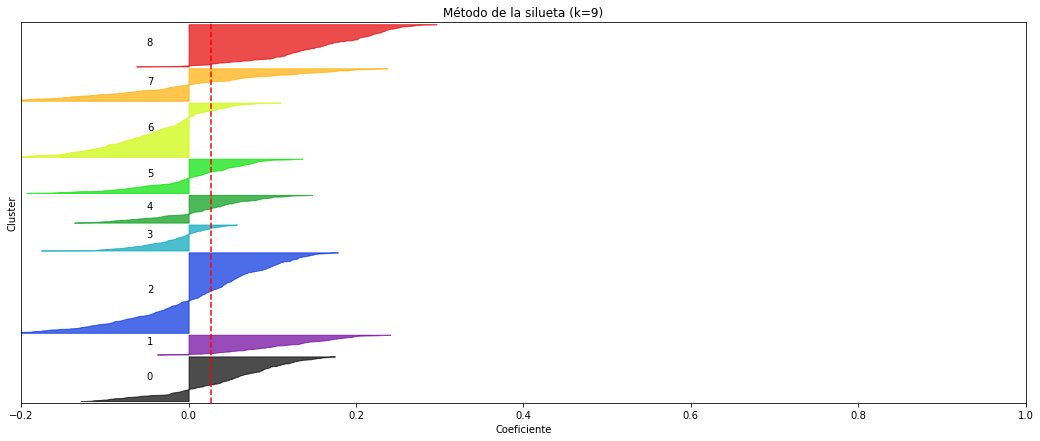

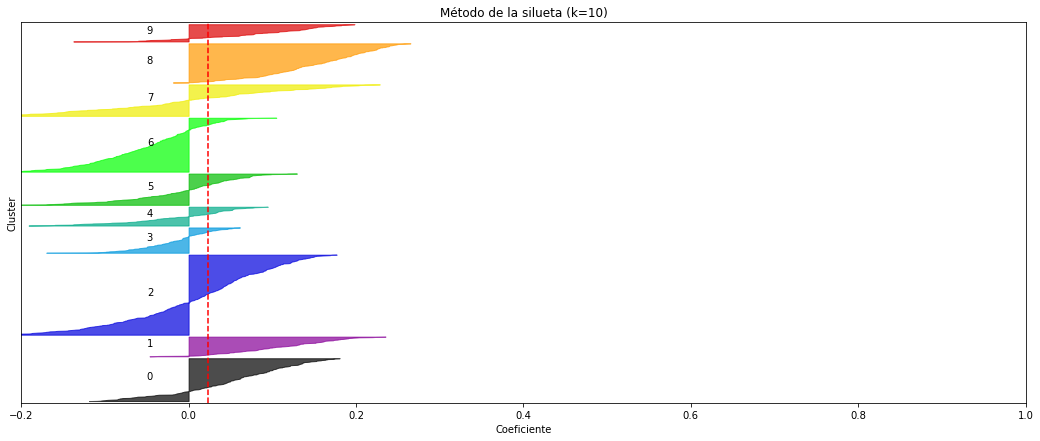

In [13]:
silhouette_analysis(data, "kmedoids", 2, 10)

Como puedes ver, todos los escenarios para el valor de _k_ resultan en ejemplos que tienen un valor negativo para el coeficiente de la silueta.

## 5. Interpretación de los grupos resultantes del mejor modelo

Con el análisis realizado para los dos algoritmos, es posible concluir que KMeans presenta un mejor desempeño con un valor de _k_ de 2. En ese sentido, ejecutaremos el algoritmo de KMeans:

In [15]:
mejor_modelo = KMeans(n_clusters=2, random_state=0)
mejor_modelo.fit(data)

KMeans(n_clusters=2, random_state=0)

Primero veremos cuántos datos hay en cada grupo, lo que nos indicará qué tantos clientes tienen comportamientos similares. Para esto utilizaremos el atributo `labels_`, que retorna un arreglo con el índice del grupo al que pertenece cada dato. Además usaremos la función `unique()` de `numpy`, que retorna los valores únicos (que almacenamos en la variable `indexes`) y la cantidad de datos por cada uno (que almacenamos en la variable `values`):

In [16]:
labels = mejor_modelo.labels_
indexes, values = np.unique(labels, return_counts=True)

{indexes[i]: values[i] for i in range(len(indexes))}

{0: 811, 1: 1247}

También podemos usar `plt.bar()` para graficar estos valores:

([<matplotlib.axis.XTick at 0x7fc8bcb9c2d0>,
 <a list of 2 Text major ticklabel objects>)

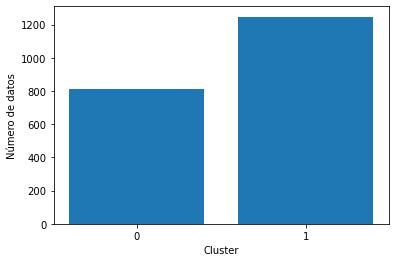

In [17]:
rects = plt.bar(indexes, values)
plt.xlabel('Cluster')
plt.ylabel('Número de datos')
plt.xticks(indexes)

### Análisis de datos por cluster

Nuestro conjunto de datos contiene variables categóricas transformadas a variables binarias mediante una codificación OneHot. Aunque la clase `StandardScaler()` permite realizar transformaciones inversas, la clase `OneHotEncoder()` no, por lo que solo realizaremos un análisis sobre las variables numéricas. Por lo tanto, primero identificaremos el objeto de la clase `StandardScaler()` dentro del `ColumnTransformer()`

In [18]:
# transformer tiene el atributo transformers, que retorna un arreglo con las tuplas definidas inicialmente
display(transformer.transformers)
# Si obtenemos el segundo objeto de la primera tupla, tendremos el StandardScaler()
standard_scaler = transformer.transformers[0][1]

[('num',
  StandardScaler(),
  ['Year_Birth',
   'Income',
   'Kidhome',
   'Teenhome',
   'Recency',
   'MntWines',
   'MntFruits',
   'MntMeatProducts',
   'MntFishProducts',
   'MntSweetProducts',
   'MntGoldProds',
   'NumDealsPurchases',
   'NumWebPurchases',
   'NumCatalogPurchases',
   'NumStorePurchases',
   'NumWebVisitsMonth',
   'AcceptedCmp3',
   'AcceptedCmp4',
   'AcceptedCmp5',
   'AcceptedCmp1',
   'AcceptedCmp2',
   'Complain',
   'Z_CostContact',
   'Z_Revenue',
   'Response']),
 ('cat', OneHotEncoder(sparse='deprecated'), ['Education', 'Marital_Status'])]

Con el objeto `standard_scaler`, podemos realizar la transformación inversa sobre las variables numéricas de nuestro conjunto de datos:

In [19]:
# Tenemos 25 variables numéricas, que corresponden a las primeras 25 columnas de la variable data
data_num = data.iloc[:, :25].copy()
# inverse_transform(data_num) retorna un arreglo de Numpy
data_original = standard_scaler.inverse_transform(data_num)
# Utilizaremos las columnas de la variable data_num para construir un DataFrame
data_original = pd.DataFrame(data_original, columns=data_num.columns)
# Si añadimos una columna con el resultado de la agrupación, 
# podremos interpretar el resultado fácilmente
data_original['Cluster'] = mejor_modelo.labels_
data_original

,num__Year_Birth,num__Income,num__Kidhome,num__Teenhome,num__Recency,num__MntWines,num__MntFruits,num__MntMeatProducts,num__MntFishProducts,num__MntSweetProducts,...,num__AcceptedCmp3,num__AcceptedCmp4,num__AcceptedCmp5,num__AcceptedCmp1,num__AcceptedCmp2,num__Complain,num__Z_CostContact,num__Z_Revenue,num__Response,Cluster
0,1957.0,58138.0,0.0,0.0,58.0,635.0,88.0,546.0,172.0,88.0,...,-1.387779e-17,0.0,0.0,0.0,-1.734723e-18,0.0,3.0,11.0,1.0,0
1,1954.0,46344.0,1.0,1.0,38.0,11.0,1.0,6.0,2.0,1.0,...,-1.387779e-17,0.0,0.0,0.0,-1.734723e-18,0.0,3.0,11.0,0.0,1
2,1965.0,71613.0,0.0,0.0,26.0,426.0,49.0,127.0,111.0,21.0,...,-1.387779e-17,0.0,0.0,0.0,-1.734723e-18,0.0,3.0,11.0,0.0,0
3,1984.0,26646.0,1.0,0.0,26.0,11.0,4.0,20.0,10.0,3.0,...,-1.387779e-17,0.0,0.0,0.0,-1.734723e-18,0.0,3.0,11.0,0.0,1
4,1981.0,58293.0,1.0,0.0,94.0,173.0,43.0,118.0,46.0,27.0,...,-1.387779e-17,0.0,0.0,0.0,-1.734723e-18,0.0,3.0,11.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,1977.0,666666.0,1.0,0.0,23.0,9.0,14.0,18.0,8.0,1.0,...,-1.387779e-17,0.0,0.0,0.0,-1.734723e-18,0.0,3.0,11.0,0.0,0
2054,1967.0,61223.0,0.0,1.0,46.0,709.0,43.0,182.0,42.0,118.0,...,-1.387779e-17,0.0,0.0,0.0,-1.734723e-18,0.0,3.0,11.0,0.0,0
2055,1981.0,56981.0,0.0,0.0,91.0,908.0,48.0,217.0,32.0,12.0,...,-1.387779e-17,1.0,0.0,0.0,-1.734723e-18,0.0,3.0,11.0,0.0,0
2056,1956.0,69245.0,0.0,1.0,8.0,428.0,30.0,214.0,80.0,30.0,...,-1.387779e-17,0.0,0.0,0.0,-1.734723e-18,0.0,3.0,11.0,0.0,0


Con las variables numéricas escaladas, realizaremos un diagrama de cajas, para así describir los clusters resultantes:

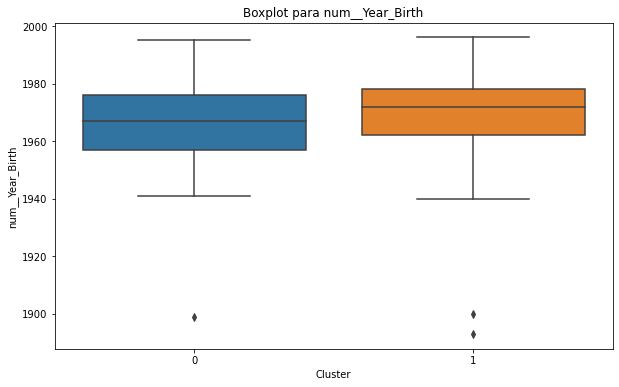

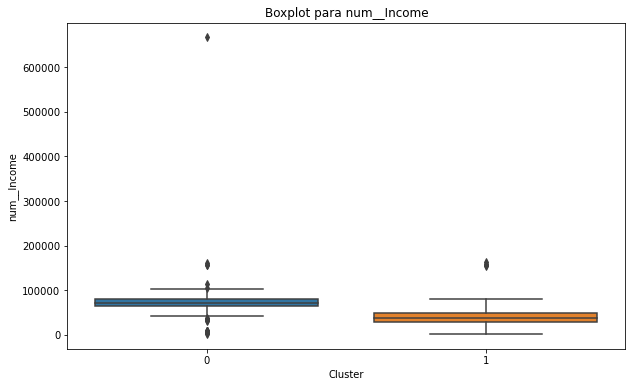

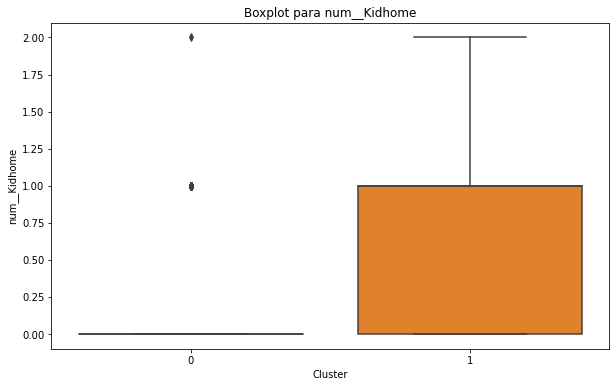

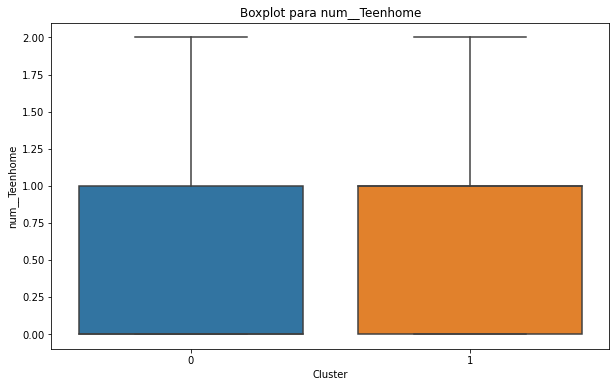

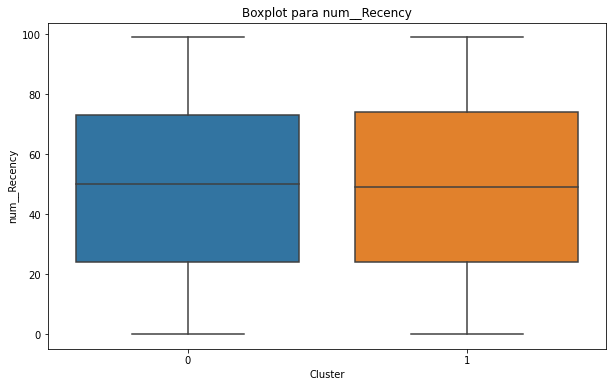

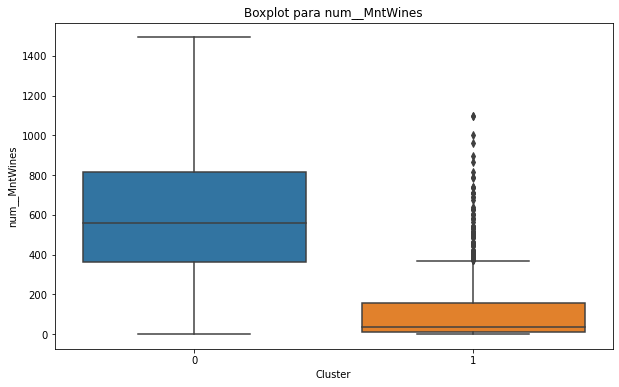

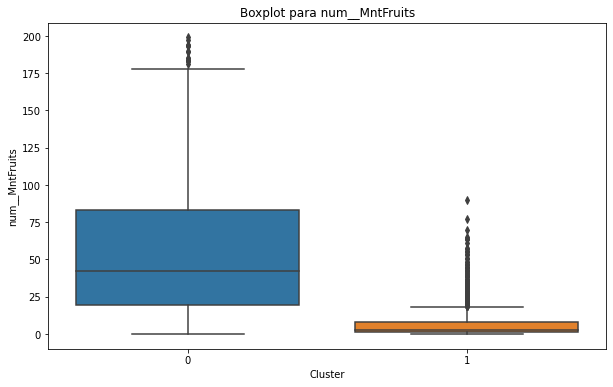

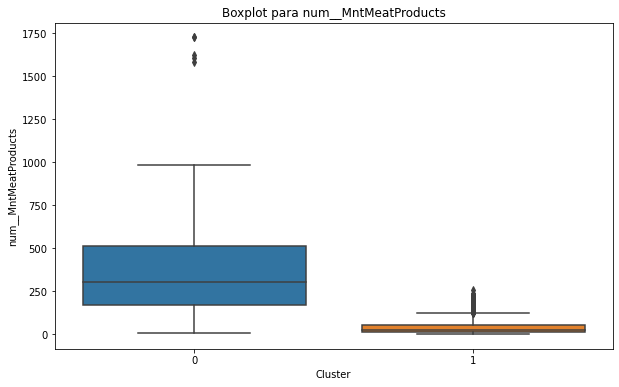

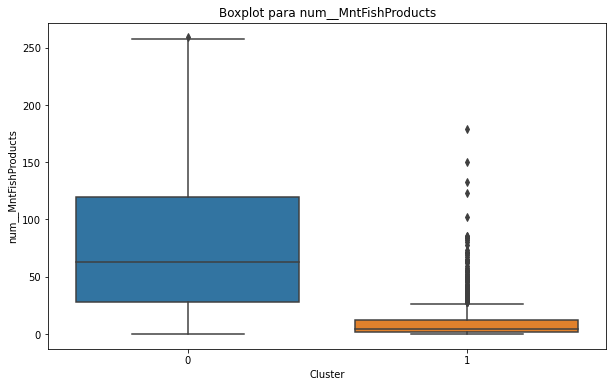

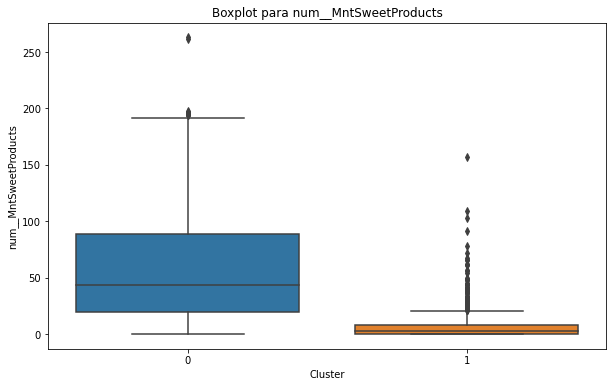

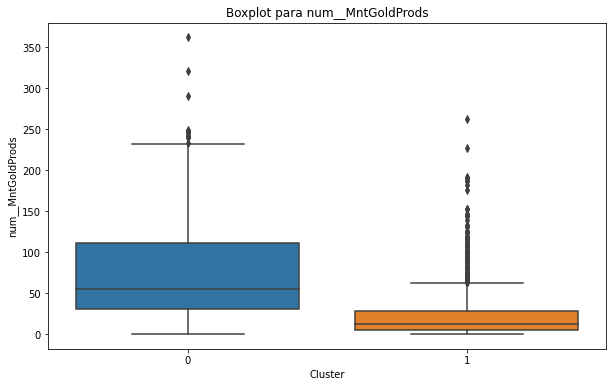

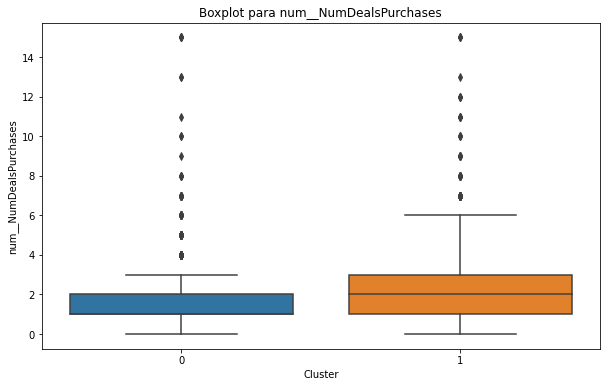

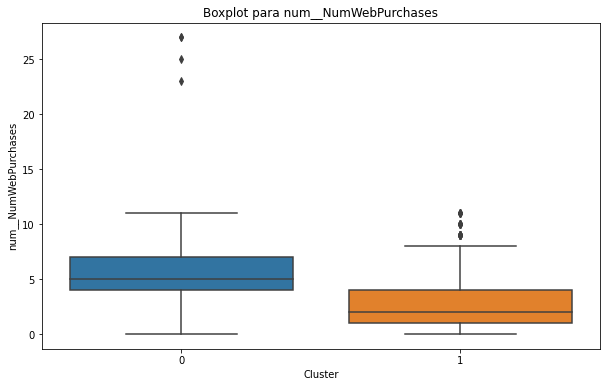

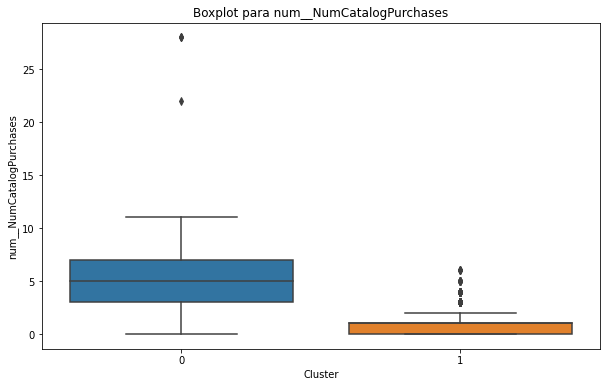

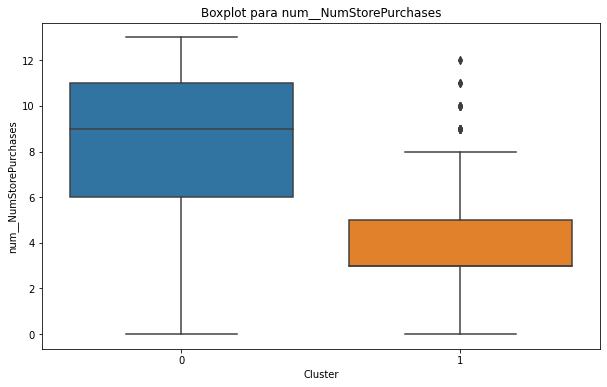

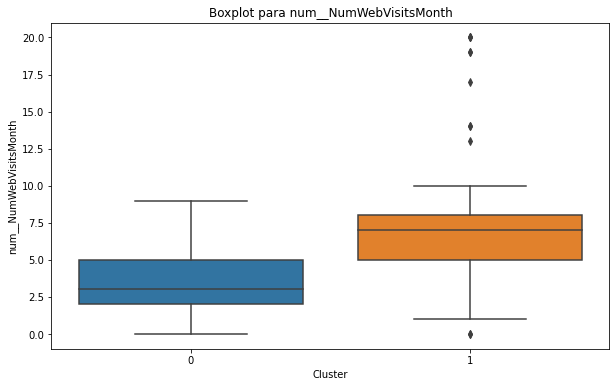

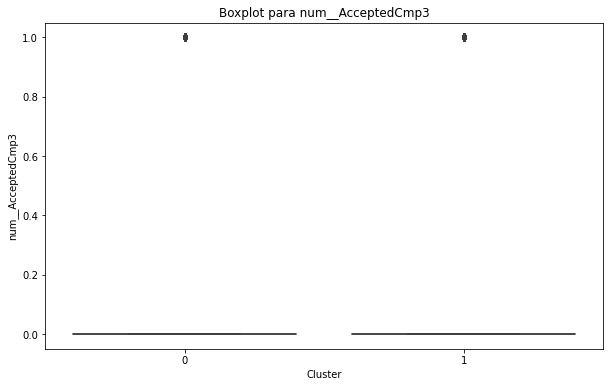

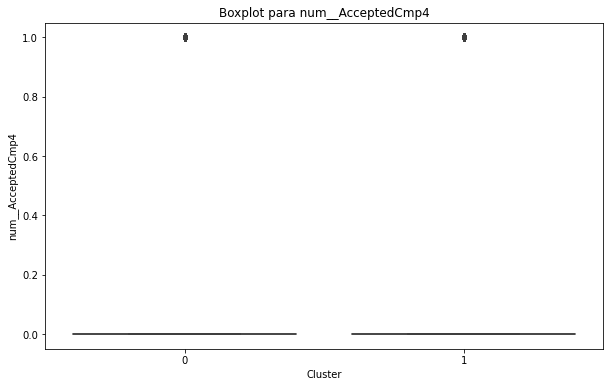

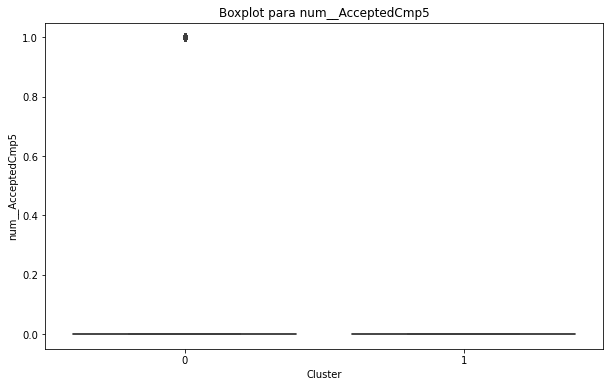

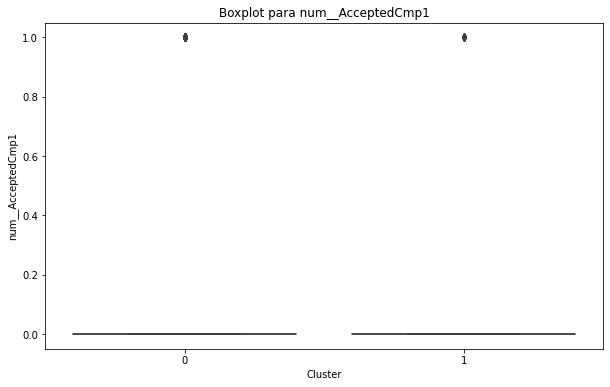

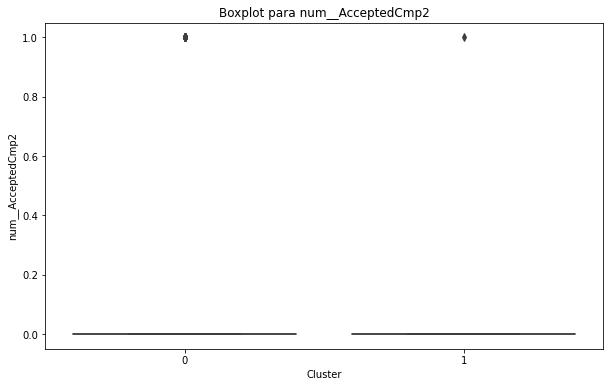

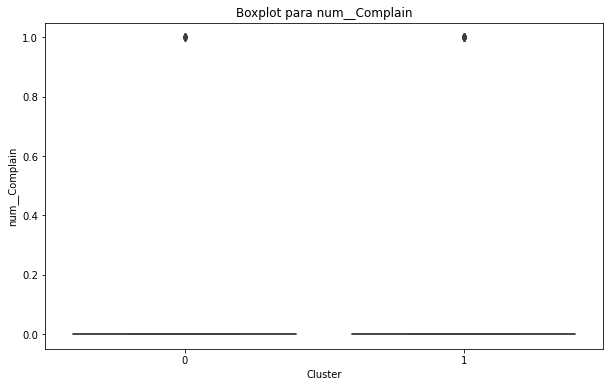

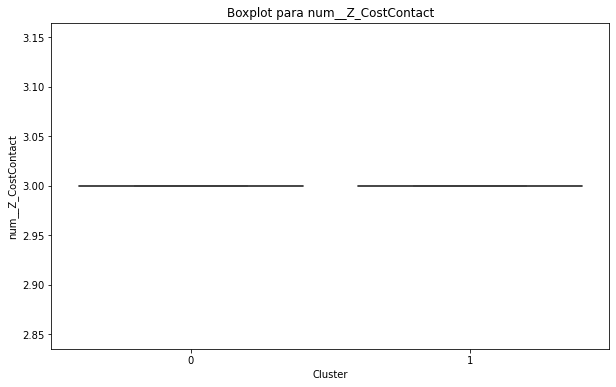

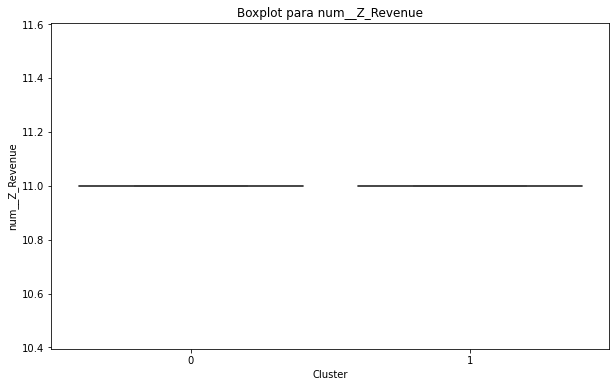

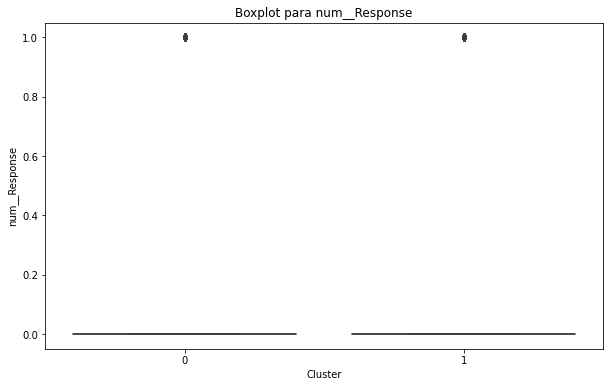

In [20]:
# Obtenemos las variables, ignorando la columna Cluster
columns = data_original.columns.drop(['Cluster'])
# Creamos un diagrama por cada variable
for column in columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=column, data=data_original)
    plt.title(f'Boxplot para {column}')
    plt.show()

A continuación, obtendremos los centroides de cada grupo con el atributo `cluster_centers_` del objeto `mejor_modelo`, pero intentaremos mantener las variables binarias. Primero construiremos un DataFrame:

In [21]:
centroids_array = mejor_modelo.cluster_centers_
centroids = pd.DataFrame(centroids_array, columns=data.columns)
centroids

,num__Year_Birth,num__Income,num__Kidhome,num__Teenhome,num__Recency,num__MntWines,num__MntFruits,num__MntMeatProducts,num__MntFishProducts,num__MntSweetProducts,...,cat__Education_Master,cat__Education_PhD,cat__Marital_Status_Absurd,cat__Marital_Status_Alone,cat__Marital_Status_Divorced,cat__Marital_Status_Married,cat__Marital_Status_Single,cat__Marital_Status_Together,cat__Marital_Status_Widow,cat__Marital_Status_YOLO
0,-0.153927,0.775384,-0.709791,-0.148924,0.005657,0.891106,0.757048,0.872295,0.777431,0.749325,...,0.149199,0.231813,2.466091e-03,-2.602085e-17,0.112207,0.372380,0.215783,0.251541,0.045623,-6.071532e-18
1,0.100108,-0.504279,0.461620,0.096854,-0.003679,-0.579540,-0.492354,-0.567307,-0.505611,-0.487332,...,0.176423,0.210104,-1.539567e-17,2.405774e-03,0.100241,0.395349,0.218925,0.254210,0.027265,1.603849e-03


Ahora aplicaremos el mismo método `inverse_transform()` para obtener centroides más interpretables:

In [22]:
# Tenemos 25 variables numéricas, que corresponden a las primeras 25 columnas
centroids_num = centroids.iloc[:, :25].copy()
# inverse_transform(centroids_num) retorna un arreglo de Numpy
centroids_original = standard_scaler.inverse_transform(centroids_num)
# Utilizaremos las columnas de la variable centroids_num para construir un DataFrame
centroids_original = pd.DataFrame(centroids_original, columns=centroids_num.columns)
centroids_original

,num__Year_Birth,num__Income,num__Kidhome,num__Teenhome,num__Recency,num__MntWines,num__MntFruits,num__MntMeatProducts,num__MntFishProducts,num__MntSweetProducts,...,num__NumWebVisitsMonth,num__AcceptedCmp3,num__AcceptedCmp4,num__AcceptedCmp5,num__AcceptedCmp1,num__AcceptedCmp2,num__Complain,num__Z_CostContact,num__Z_Revenue,num__Response
0,1966.944513,71858.525277,0.064118,0.427867,49.115906,603.731196,56.320592,366.803946,79.811344,58.426634,...,3.668311,0.081381,0.131936,1.824908e-01,0.157830,0.030826,0.008631,3.0,11.0,0.236745
1,1969.985565,38811.935846,0.693665,0.562149,48.845229,108.937450,6.668003,38.218123,9.700882,6.853248,...,6.393745,0.068164,0.040898,1.401657e-15,0.005613,0.000802,0.010425,3.0,11.0,0.097033


Para mantener las variables binarias, utilizaremos la función `pd.concat()` para combinar dos DataFrames, especificando un arreglo con las variables `centroids_original` y `centroids_cat`, así como el parámetro `axis=1` para indicar que realizaremos la operación sobre las columnas:

In [23]:
# Las variables categóricas inician desde la columna 26
centroids_cat = centroids.iloc[:, 25:].copy()
# Juntaremos las columnas numéricas y categóricas
centroids_total = pd.concat([centroids_original, centroids_cat], axis=1)
centroids_total

,num__Year_Birth,num__Income,num__Kidhome,num__Teenhome,num__Recency,num__MntWines,num__MntFruits,num__MntMeatProducts,num__MntFishProducts,num__MntSweetProducts,...,cat__Education_Master,cat__Education_PhD,cat__Marital_Status_Absurd,cat__Marital_Status_Alone,cat__Marital_Status_Divorced,cat__Marital_Status_Married,cat__Marital_Status_Single,cat__Marital_Status_Together,cat__Marital_Status_Widow,cat__Marital_Status_YOLO
0,1966.944513,71858.525277,0.064118,0.427867,49.115906,603.731196,56.320592,366.803946,79.811344,58.426634,...,0.149199,0.231813,2.466091e-03,-2.602085e-17,0.112207,0.372380,0.215783,0.251541,0.045623,-6.071532e-18
1,1969.985565,38811.935846,0.693665,0.562149,48.845229,108.937450,6.668003,38.218123,9.700882,6.853248,...,0.176423,0.210104,-1.539567e-17,2.405774e-03,0.100241,0.395349,0.218925,0.254210,0.027265,1.603849e-03


Con los clústeres reconstruidos, podemos realizar una caracterización:

- **Clúster 0 (808 muestras):** en promedio, presenta valores muy altos de ingresos (variable `num__Income`), valores más bajos para la cantidad de niños en casa (variable `num__Kidhome`), y valores más altos para variables de consumo (como `num__MntWines`, `num__MntFruits` o `num__MntMeatProducts`). 

- **Clúster 1 (1250 muestras):** se caracteriza por tener ingresos más bajos (variable `num__Income`), valores más altos para cantidades de niños y adolescentes en casa (`num__Kidhome` y `num__Teenhome`) y los valores más bajos de consumos de productos.

## Cierre

En este tutorial hemos utilizado las clases `KMeans` y `KMedoids` para entrenar y evaluar modelos de agrupación en un conjunto de datos sin grupos fácilmente separables. Específicamente, realizamos una selección del hiperparámetro _k_ mediante el método del codo y el método de la silueta, interpretando los _k_ grupos resultantes mediante la identificación de sus centroides y la generación de diagramas de caja con `seaborn`.

<font size="3">**Hands-on**  

* Los algoritmos de agrupación pueden ser utilizados con subconjuntos de variables, ¿qué pasaría si solo utilizamos las variables numéricas, ignorando las categóricas?
* Para este conjunto de datos no hicimos el análisis de valores extremos ¿Los resultados podrían ser diferentes si estos datos son tratados? Por ejemplo, utilizando en la etapa de preparación un RobustScaler.    
    

---
*Creado por: Nicolás Díaz*  
*Revisado por: Haydemar Nuñez*  
*Versión de: Diciembre 13, 2023*  
*Universidad de los Andes*   